In [1]:
# The following notebook is based entirely on 
# this script from AGAMA: 
# https://github.com/GalacticDynamics-Oxford/Agama/blob/c507fc3e703513ae4a41bb705e171a4d036754a8/py/example_lmc_mw_interaction.py
import sys
sys.path.append('../')
import potential as potlib
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp

import diffrax
import fields as fields

import StreamSculptor
import potential
import matplotlib.pyplot as plt
import numpy as np
import jax
import RestrictedNbody
jax.config.update("jax_enable_x64", True)

from functools import partial
import interpax
from fields import integrate_field
# agama imports
import agama
import numpy as np, numpy

from InterpAGAMA import AGAMA_Spheroid

In [2]:
agama.setUnits(length=1, velocity=1, mass=1)  # work in units of 1 kpc, 1 km/s, 1 Msun)
timeUnitMyr = agama.getUnits()['time'] #agama time unit in Myr


In [3]:
### Below we start with the AGAMA setup. No jax in this cell.

Trewind = -4_000.0#-4000.0  # initial time [Myr] - the LMC orbit is computed back to that time
Tcurr   =  0.0  # current time
# heliocentric ICRS celestial coordinates and velocity of the LMC
# (PM from Luri+ 2021, distance from Pietrzynski+ 2019, center and velocity from van der Marel+ 2002)
ra, dec, dist, pmra, pmdec, vlos = 81.28, -69.78, 49.6, 1.858, 0.385, 262.2
# transform to Galactocentric cartesian position/velocity, using built-in routines from Agama
# (hence the manual conversion factors from degrees to radians and from mas/yr to km/s/kpc)
l, b, pml, pmb = agama.transformCelestialCoords(agama.fromICRStoGalactic,
    ra * np.pi/180, dec * np.pi/180, pmra, pmdec)
posvelLMC = agama.getGalactocentricFromGalactic(l, b, dist, pml*4.74, pmb*4.74, vlos)

# Create a simple but realistic model of the Milky Way with a bulge, a single disk,
# and a spherical dark halo
paramBulge = dict(
    type              = 'Spheroid',
    mass              = 1.2e10,
    scaleRadius       = 0.2,
    outerCutoffRadius = 1.8,
    gamma             = 0.0,
    beta              = 1.8)
paramDisk  = dict(
    type='Disk',
    mass              = 5.0e10,
    scaleRadius       = 3.0,
    scaleHeight       = -0.4)
paramHalo  = dict(
    type              = 'Spheroid',
    densityNorm       = 1.35e7,
    scaleRadius       = 14,
    outerCutoffRadius = 300,
    cutoffStrength    = 4,
    gamma             = 1,
    beta              = 3)
# Mass in spheroid is _total mass_
massLMC    = 1.5e11
radiusLMC  = (massLMC/1e11)**0.6 * 8.5
paramLMC = dict(
    type              = 'spheroid',
    mass              = massLMC,
    scaleRadius       = radiusLMC,
    outerCutoffRadius = radiusLMC*10,
    gamma             = 1,
    beta              = 3
    )
    

densMWhalo = agama.Density(paramHalo)
potMW      = agama.Potential(paramBulge, paramDisk, paramHalo)

# create a sphericalized MW potential and a corresponding isotropic halo distribution function
potMWsph   = agama.Potential(type='Multipole', potential=potMW, lmax=0, rmin=0.01, rmax=1000)
gmHalo     = agama.GalaxyModel(potMWsph,
    agama.DistributionFunction(type='quasispherical', density=densMWhalo, potential=potMWsph))

# compute the velocity dispersion in the MW halo needed for the dynamical friction
rgrid      = numpy.logspace(.01, 3, 32)
xyzgrid    = numpy.column_stack([rgrid, rgrid*0, rgrid*0])
sigma_eval  = gmHalo.moments(xyzgrid, dens=False, vel=False, vel2=True)[:,0]**0.5

# Create the LMC potential - a spherical truncated NFW profile with mass and radius
# related by the equation below, which produces approximately the same enclosed mass
# profile in the inner region, satisfying the observational constraints, as shown
# in Fig.3 of Vasiliev,Belokurov&Erkal 2021.
bminCouLog = radiusLMC * 2.0   # minimum impact parameter in the Coulomb logarithm
potLMC     = agama.Potential(paramLMC)

In [4]:
# Next we follow the steps below
# [Step 1]: Convert AGAMA potential to StreamSculptor Potentials
# [Step 2]: Convert dynamical friction sigmafnc (computed with AGAMA) to a jax interpolated array

# [Step 1]

pot_bulge_jax = AGAMA_Spheroid(**paramBulge)
pot_disk_jax = potential.MiyamotoNagaiDisk(m=paramDisk['mass'], a=paramDisk['scaleRadius'], b=paramDisk['scaleHeight'], units=usys)
pot_halo_jax = AGAMA_Spheroid(**paramHalo)
pot_MW_lst = [pot_bulge_jax, pot_disk_jax, pot_halo_jax]
pot_MW_jax = potential.Potential_Combine(pot_MW_lst, units=usys)

pot_LMC_jax = AGAMA_Spheroid(**paramLMC)

# [Step 2]
sigmafnc = interpax.Interpolator1D(x=rgrid, f=sigma_eval*(u.km/u.s).to(u.kpc/u.Myr), method='cubic2')



In [12]:
from fields import MW_LMC_field
field = MW_LMC_field(pot_MW=pot_MW_jax, pot_LMC=pot_LMC_jax, sigma_func=sigmafnc, bminCouLog=bminCouLog)

In [14]:
ICs_MW = jnp.zeros(6) # MW at origin at rest at t0
init_pos_LMC= np.hstack(posvelLMC)[:3]
init_vel_LMC= np.hstack(posvelLMC)[3:]*(u.km/u.s).to(u.kpc/u.Myr)
ICs_LMC = jnp.hstack([init_pos_LMC, init_vel_LMC])

ICs_total = [ICs_MW, ICs_LMC]
tsave = jnp.linspace(Trewind, Tcurr, 500)[::-1]
out = integrate_field(w0=ICs_total, ts=tsave, field=field, max_steps=10_000,solver=diffrax.Dopri5(),backwards_int=True)

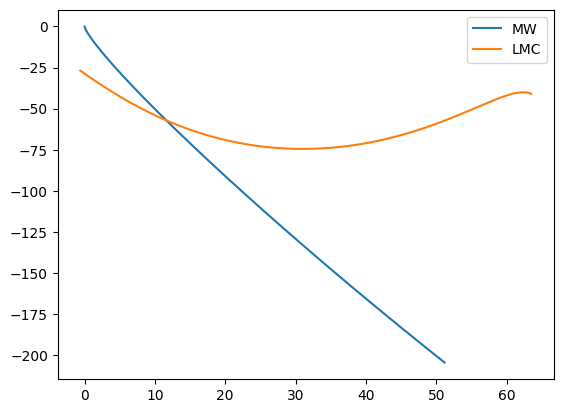

In [15]:
plt.plot(out.ys[0][:,0], out.ys[0][:,2], label='MW')
plt.plot(out.ys[1][:,0], out.ys[1][:,2], label='LMC')
plt.legend()